# time-series based failure forecasting problem

**Failure Forecasting Exercise**

**Problem Statement:**

The dataset provided is for a number of oil wells and their KPI's (key performance metrics). The wells provided have 2 conditions:
- Normal: Label = 0
- Failure: Label = 1 

The client wants an algorithm which can forecast failures 5 days in advance.
  
**Data set Info**

The dataset is labeled and here's a quick overview of the data columns:

- `NodeID`: The well-name. The dataset containes samples from multiple oil wells and this column has the names of each well.
- `Date`: Timestamp. Datapoints are sampled with a frequency of `1 hour`
- `Label`: Binary labels of 0 and 1 where 1 indicates failure. 
- The remaining columns represent data from various sensors. 
    - MotorCurrent
    - Frequency
    - PIP
    - TubingPressure
    - CasingPressure
    - PIT
    - MotorTemperature
    - XVIB



### REFERENCE
https://github.com/hfawaz/dl-4-tsc/
https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
https://keras.io/guides/keras_tuner/getting_started/

# Preprocessing

In [367]:
# intallation
!pip install s3fs

In [271]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [374]:
data = pd.read_csv('s3://enfinite-public/sample_data/sample_esp.csv', parse_dates=['Date'])
# Importing the dataset
print('Data Sample:')
display(data.sample(5))

print('\nTotal Wells in the Data:', *data.NodeID.unique(), sep='\n')

print(f'\nOverall label Distribution:\n0 - {data.Label.value_counts()[0]}\n1 - {data.Label.value_counts()[1]} ')

print("\n\nNAN Value distribution:\n" )
display(data.isnull().sum(axis=0))

print("Zero Value distribution:\n" )
display((data == 0).sum(axis=0))

# List of Wells
nodeid=data.NodeID.unique().tolist()
#list of Columns
columns=data.columns.tolist()


Data Sample:


,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
21362,Well J,2020-02-04 17:00:00,25.916667,62.000000,827.166667,217.625000,1273.833333,231.000000,257.916667,208.083333,0
1020,Well A,2020-02-21 12:00:00,31.000000,59.000000,470.833333,221.000000,124.000000,247.000000,277.000000,1.750000,0
26159,Well L,2020-05-03 12:00:00,24.916667,62.833333,1182.500000,202.458333,134.000000,256.833333,288.833333,103.500000,1
19670,Well J,2019-11-26 05:00:00,25.916667,62.000000,849.166667,234.333333,111.083333,231.000000,257.833333,215.916667,0
14390,Well G,2019-11-23 08:00:00,36.833333,57.000000,925.000000,208.500000,0.000000,257.000000,258.000000,1.000000,0



Total Wells in the Data:
Well A
Well B
Well C
Well D
Well E
Well F
Well G
Well H
Well I
Well J
Well K
Well L

Overall label Distribution:
0 - 24192
1 - 2028 


NAN Value distribution:



NodeID                0
Date                  0
MotorCurrent        595
Frequency           595
PIP                 595
TubingPressure      595
CasingPressure      595
PIT                 595
MotorTemperature    595
XVib                595
Label                 0
dtype: int64

Zero Value distribution:



NodeID                  0
Date                    0
MotorCurrent         1118
Frequency            1119
PIP                   265
TubingPressure         74
CasingPressure       1372
PIT                   224
MotorTemperature      224
XVib                  269
Label               24192
dtype: int64

In [370]:
def well_dict(data):
    wells={}
    for i in range(len(nodeid)):
        d=data[data['NodeID']==nodeid[i]]
        wells[nodeid[i]]=d
    return wells

def size_pie_chart(wells):
    well_length=[]
    for k in wells:
        well_length.append(len(wells[k]))
    plt.subplot(1, 1, 1)
    plt.pie(np.array(well_length),labels=nodeid)
    # plt.subplot(2, 1, 2)
    # plt.hist(well_length)
    plt.show()

def nan_distribution(wells):
    perofnan=[]
    for i in nodeid:
        temp=[]
        d=wells[i]
        nan_df=d[d.isna().any(axis=1)]
#         print(i,len(nan_df),len(d))
#         print(len(nan_df))
        perofnan.append((len(nan_df)/len(d)))
    perofnan=[i * 100 for i in perofnan]
#     print(perofnan)
    plt.subplot(1, 1, 1)
    plt.title('Percentage of NAN value')
    plt.bar(np.array(nodeid),np.array(perofnan))
    plt.xticks(rotation=90)
    plt.show()

def time_plot(wells):
    event_data = data.loc[data['Label'] == 1]
    event_data=event_data[['NodeID','Date']]
    event_node=event_data['NodeID'].tolist()
    event_time=event_data['Date'].tolist()
    times=[]

    maxdate=data['Date'].max()
    mindate=data['Date'].min()
    for i in nodeid:
        d=wells[i]
        times.append(d.Date.unique())

    for i in range(len(times)):
        plt.plot(times[i],[nodes[i]]*len(times[i]),)

    plt.scatter(event_time,event_node,c='red')
    plt.xticks(rotation=90)
    plt.title('Distribution of collected Data in Time')
    plt.show()

def normalize_data(data):
    for column in data.columns[2:]:
        data[column] = data[column]  / data[column].abs().max()
    return data

In [371]:
def replace_zero_nan(data):
    print("NAN Value distribution:\n" )
    display(data.isnull().sum(axis=0))
    print("Zero Value distribution:\n" )
    display((data == 0).sum(axis=0))
    for cols in columns[:-1]:
        data[cols].replace(0,np.nan,inplace=True)
    print("AFTER REPLACING : ")
    print("NAN Value distribution:\n" )
    display(data.isnull().sum(axis=0))
    print("Zero Value distribution:\n" )
    display((data == 0).sum(axis=0))
    return data

def label_distribution(data):
    print(f'\nOverall label Distribution:\n0 - {data.Label.value_counts()[0]}\n1 - {data.Label.value_counts()[1]} ')

def remove_nan(data):
    clean_data=data.dropna()
    print("ORIGINAL DATA")
    print("LENGTH OF DATA:",len(data))
    label_distribution(data)
    print("CLEAN DATA")
    print("LENGTH OF CLEAN DATA:",len(clean_data))
    label_distribution(clean_data)
    return clean_data



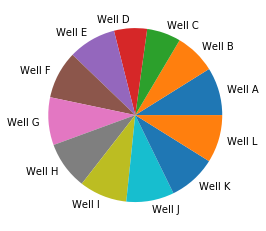

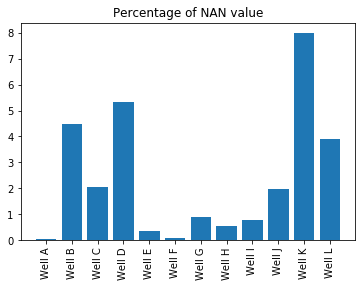

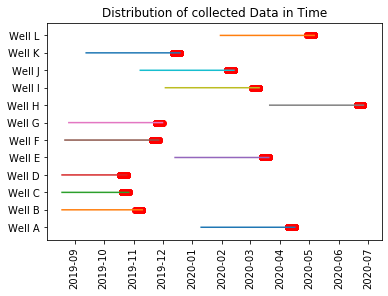

In [376]:
wells=well_dict(data)
size_pie_chart(wells)
nan_distribution(wells)
time_plot(wells)

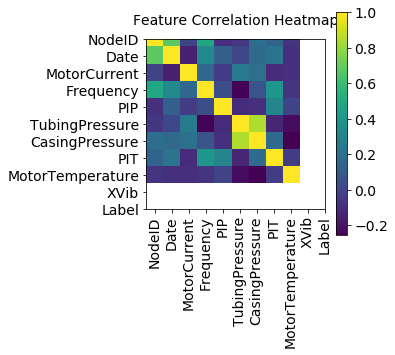

In [377]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
show_heatmap(data)

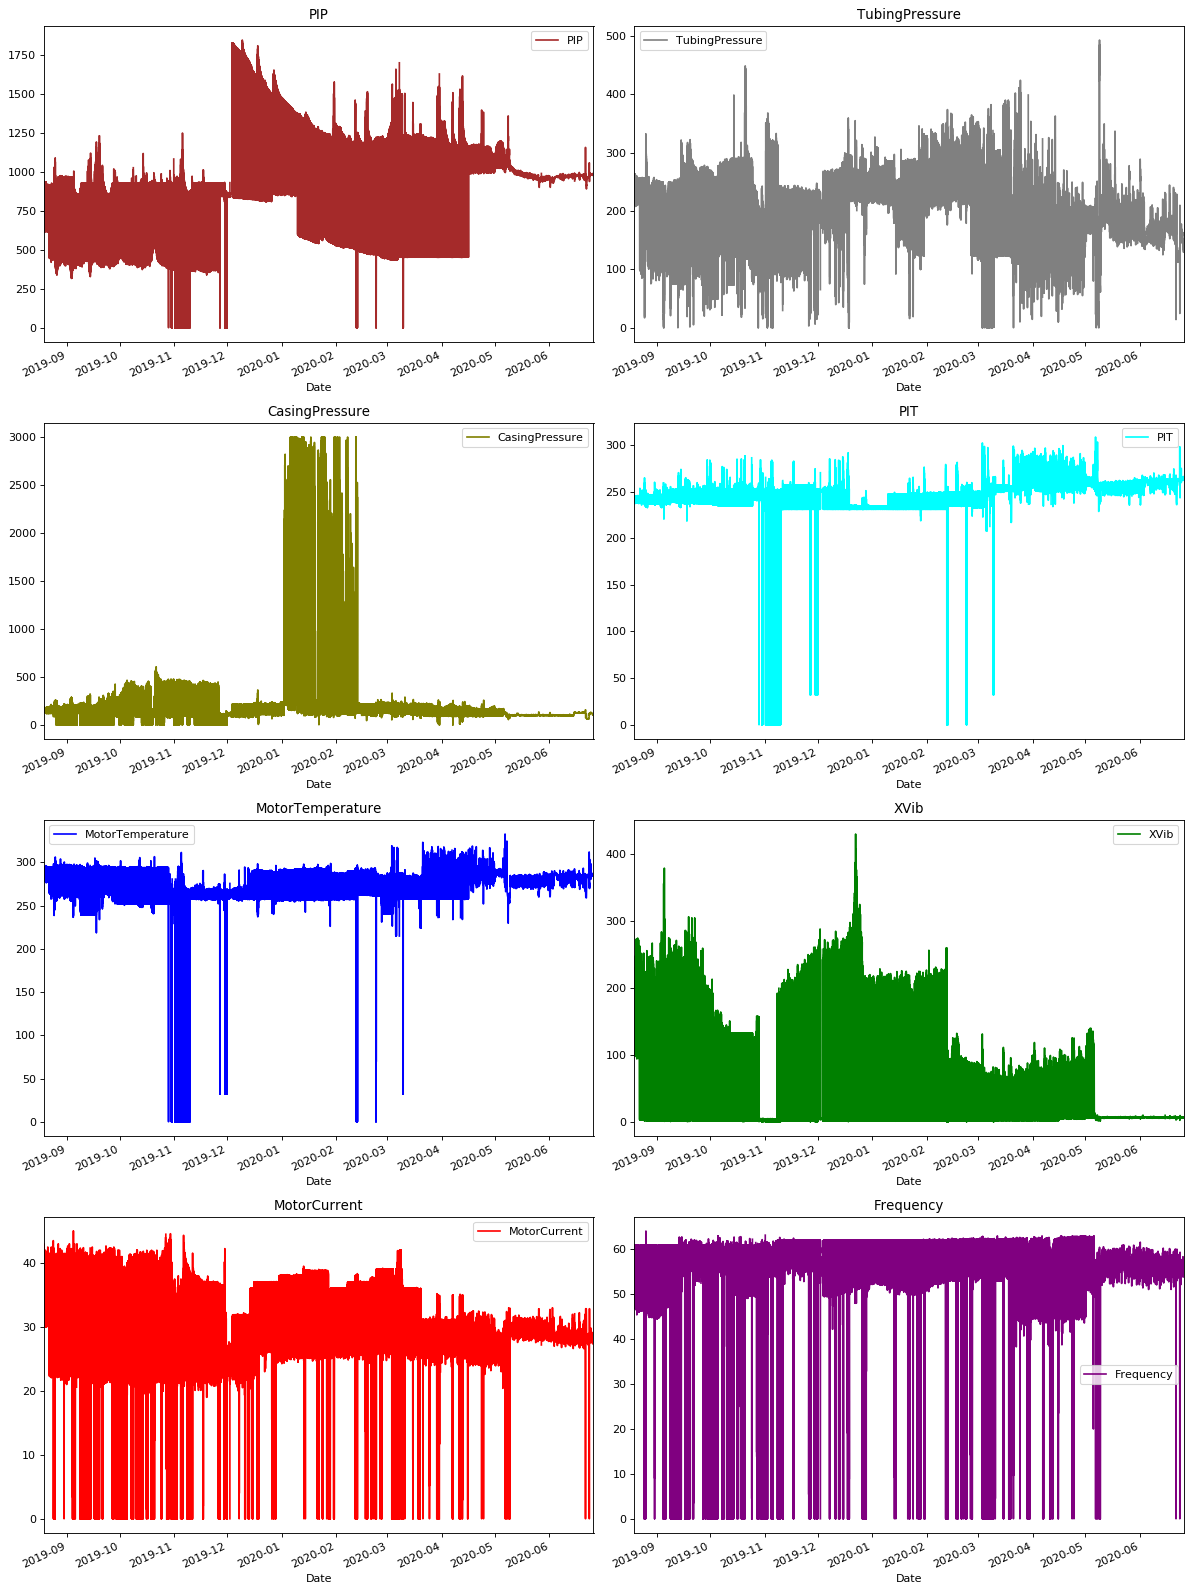

In [378]:
colors = [
    "blue",
    "green",
    "red",
    "purple",
    "brown",
    "gray",
    "olive",
    "cyan",
]
def show_raw_visualization(data):
    time_data = data['Date']
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(2,10):
        key = columns[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[(i // 2)-2, (i % 2)-2],
             title=columns[i],
            color=c,
            rot=25,
        )
        
        ax.legend([columns[i]])
    plt.tight_layout()
    
show_raw_visualization(data)

###### One Hot Eencoding

In [379]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

label_encoder = preprocessing.LabelEncoder()
data['NodeID']= label_encoder.fit_transform(data['NodeID']) 

onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(data.NodeID.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns = nodes) 
df = pd.concat([data, dfOneHot], axis=1)
df= df.drop(['NodeID'], axis=1) 
display(df.head())

C:\Users\jaisa\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label,...,Well C,Well D,Well E,Well F,Well G,Well H,Well I,Well J,Well K,Well L
0,2020-01-10 00:00:00,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-10 01:00:00,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-10 02:00:00,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-10 03:00:00,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-10 04:00:00,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
display(train.head())
display(test.head())

,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label,...,Well C,Well D,Well E,Well F,Well G,Well H,Well I,Well J,Well K,Well L
5720,2019-10-16 06:00:00,0.690741,0.780234,0.370952,0.435884,0.039389,0.791678,0.842013,0.250388,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602,2020-05-02 19:00:00,0.617172,0.792845,0.561545,0.333042,0.033030,0.847732,0.857650,0.013531,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12034,2019-11-18 05:00:00,0.475926,0.901170,0.195412,0.205271,0.142500,0.798433,0.798948,0.009884,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15278,2020-04-19 07:00:00,0.640741,0.842848,0.560841,0.366616,0.030861,0.863821,0.872058,0.014729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19537,2019-11-20 16:00:00,0.587037,0.967490,0.462765,0.471617,0.038194,0.748987,0.775663,0.469186,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label,...,Well C,Well D,Well E,Well F,Well G,Well H,Well I,Well J,Well K,Well L
9939,2019-08-22 22:00:00,0.535185,0.928479,0.245089,0.247001,0.058389,0.803296,0.802704,0.007946,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2152,2020-04-08 16:00:00,0.685185,0.928999,0.245224,0.216929,0.036667,0.830046,0.775163,0.004651,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25213,2020-03-25 02:00:00,0.605556,0.962289,0.658944,0.450667,0.065889,0.814915,0.852529,0.153101,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14085,2019-11-10 15:00:00,0.846296,0.889467,0.453462,0.446021,0.030667,0.771683,0.803706,0.004651,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6119,2019-08-24 20:00:00,0.900000,0.838752,0.345346,0.447542,0.043750,0.770062,0.887081,0.363953,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [330]:
label_distribution(df)


Overall label Distribution:
0 - 21686
1 - 1504 


TEST DATA
Size :  20976

Overall label Distribution:
0 - 4842
1 - 402 


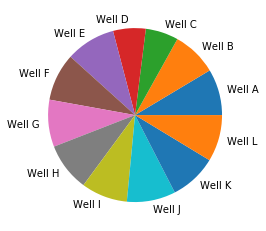

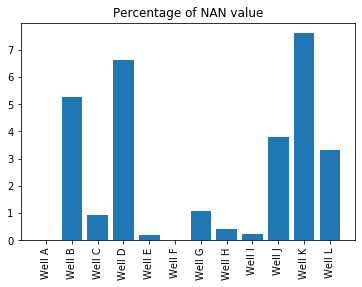

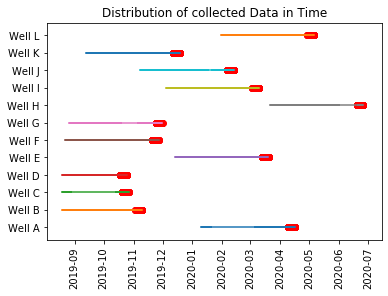

In [15]:
print("TEST DATA")
print("Size : ",len(test))
label_distribution(test)
wells_test=well_dict(test)
size_pie_chart(wells_test)
nan_distribution(wells_test)
time_plot(wells_test)

TRAIN DATA
Size :  20976

Overall label Distribution:
0 - 19350
1 - 1626 


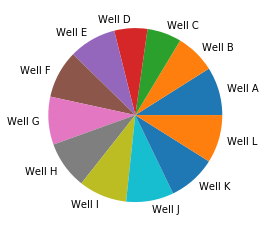

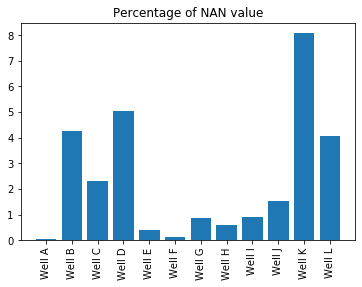

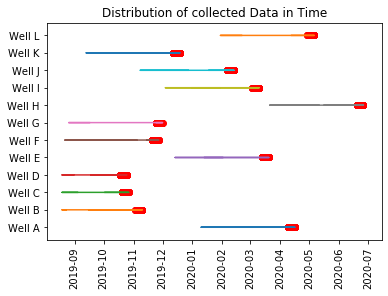

In [23]:
print("TRAIN DATA")
print("Size : ",len(train))
label_distribution(train)
wells_train=well_dict(train)
size_pie_chart(wells_train)
nan_distribution(wells_train)
time_plot(wells_train)

In [331]:
def x_y_split(data):
        x = data.drop(['Label'], axis=1)
        y = data['Label']
        return x,y

In [332]:
x_train,y_train=x_y_split(train)
x_test,y_test=x_y_split(test)
x_train_features=x_train.drop(['Date'],axis=1)
x_train_features.index = x_train['Date']
x_test_features=x_test.drop(['Date'],axis=1)
x_test_features.index = x_test['Date']
display(x_train_features.head())
display(x_test_features.head())

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Well A,Well B,Well C,Well D,Well E,Well F,Well G,Well H,Well I,Well J,Well K,Well L
Date,,,,,,,,,,,,,,,,,,,,
2019-10-16 06:00:00,0.690741,0.780234,0.370952,0.435884,0.039389,0.791678,0.842013,0.250388,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-02 19:00:00,0.617172,0.792845,0.561545,0.333042,0.033030,0.847732,0.857650,0.013531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-11-18 05:00:00,0.475926,0.901170,0.195412,0.205271,0.142500,0.798433,0.798948,0.009884,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-04-19 07:00:00,0.640741,0.842848,0.560841,0.366616,0.030861,0.863821,0.872058,0.014729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-11-20 16:00:00,0.587037,0.967490,0.462765,0.471617,0.038194,0.748987,0.775663,0.469186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Well A,Well B,Well C,Well D,Well E,Well F,Well G,Well H,Well I,Well J,Well K,Well L
Date,,,,,,,,,,,,,,,,,,,,
2019-08-22 22:00:00,0.535185,0.928479,0.245089,0.247001,0.058389,0.803296,0.802704,0.007946,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08 16:00:00,0.685185,0.928999,0.245224,0.216929,0.036667,0.830046,0.775163,0.004651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-25 02:00:00,0.605556,0.962289,0.658944,0.450667,0.065889,0.814915,0.852529,0.153101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-10 15:00:00,0.846296,0.889467,0.453462,0.446021,0.030667,0.771683,0.803706,0.004651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-08-24 20:00:00,0.900000,0.838752,0.345346,0.447542,0.043750,0.770062,0.887081,0.363953,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [348]:
temp=x_train_features.values
temp = temp.reshape((temp.shape[0], temp.shape[1], 1))
temp2=y_train.values

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    padding = 'same'
    conv1 = keras.layers.Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid')(input_layer)
    conv1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

    conv2 = keras.layers.Conv1D(filters=12,kernel_size=7,padding=padding,activation='sigmoid')(conv1)
    conv2 = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    flatten_layer = keras.layers.Flatten()(conv2)
    
    output_layer = keras.layers.Dense(units=2,activation='sigmoid')(flatten_layer)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=temp.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)
epochs = 10
batch_size = 10

model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", monitor='loss',save_best_only=True)
callbacks = [model_checkpoint]
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(
    temp,
    temp2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
1667/1667 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 2/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 3/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 4/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 5/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 6/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 7/10
1667/1667 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.8362 - val_loss: nan - val_accuracy: 0.8308
Epoch 8/10
1667/1667 [============

In [360]:
# t=x_test_features.values
# t = t.reshape((t.shape[0], t.shape[1], 1))
# y_pred = model.predict(t)
test_loss, test_acc = model.evaluate(x_test_features, y_test)

163/163 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8241


Test accuracy 0.8241167664527893
Test loss nan


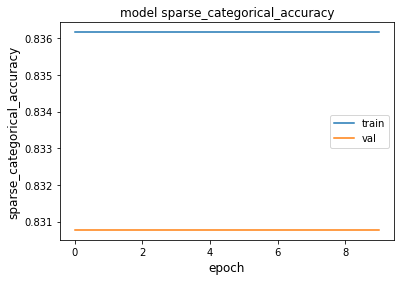

In [366]:
print("Test accuracy", test_acc)
print("Test loss", test_loss)
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_" + 'accuracy'])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()


In [338]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    padding = 'same'
    conv1 = keras.layers.Conv1D(filters=6,kernel_size=7,padding=padding,activation='sigmoid')(input_layer)
    conv1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)

    conv2 = keras.layers.Conv1D(filters=12,kernel_size=7,padding=padding,activation='sigmoid')(conv1)
    conv2 = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    flatten_layer = keras.layers.Flatten()(conv2)
    
    output_layer = keras.layers.Dense(units=2,activation='sigmoid')(flatten_layer)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=temp.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)


In [347]:
epochs = 10
batch_size = 10

model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", monitor='loss',save_best_only=True)
callbacks = [model_checkpoint]
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(
    temp,
    temp2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

AttributeError: 'TFLiteKerasModelConverterV2' object has no attribute 'compile'

In [261]:
t=x_test_features.values
t = t.reshape((t.shape[0], t.shape[1], 1))
t2=y_test.values

In [346]:
# model = keras.models.load_model("best_model.h5")
import tensorflow as tf
model=tf.lite.TFLiteConverter.from_keras_model("best_model.h5")
y_pred = model.predict(x_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

AttributeError: 'TFLiteKerasModelConverterV2' object has no attribute 'predict'

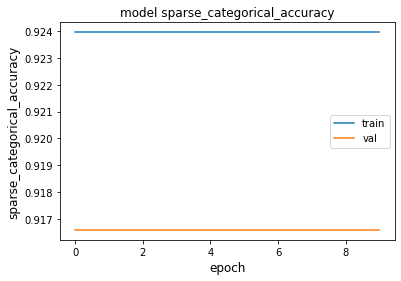

In [268]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

###### Making Training Dataset

In [230]:
y_train=y_train.astype(np.float32)

for i in x_train_features.columns:
    x_train_features[i] = x_train_features[i].astype(np.float32)
temp=np.asarray(x_train_features.values).astype(np.float32)
temp2=np.asarray(y_train.values).astype(np.float32)
# print(temp)

In [231]:
step = 6
learning_rate = 0.001
batch_size = 256
epochs = 10
sequence_length=12
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train_features,
    temp2,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)